# Jupiter-like Cloud Model and Reflection Spectrum 

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Sets an atmosphere model

In [2]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=2.0, nlayer=100)
alpha = 0.097
T0 = 200.
Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)

g=1.e5

`pdb` is a class for particulates databases. We here use `PdbCloud` for NH3, i.e. `pdb` for the ammonia cloud. 
PdbCloud uses the refaction (refractive) indice given by VIRGA. The Mie parameters assuming a log-normal distribution is called `miegrid`. This can be computed pdb.generate_miegrid if you do not have it. To compute `miegrid`, we use PyMieScatt as a calculator.   

Also, `amp` is a class for atmospheric micorphysics. AmpAmcloud is the class for the Akerman and Marley 2001 cloud model (AM01). We adopt the background atmosphere to hydorogen atmosphere.

In [4]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
pdb_nh3.load_miegrid()

amp_nh3 = AmpAmcloud(pdb_nh3,bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


/home/kawahara/exojax/src/exojax/atm/atmphys.py:49: UserWarning: min temperature 65.4681396484375 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


Sets the parameters in the AM01 cloud model. `calc_ammodel` method computes the vertical distribution of `rg` and the condensate volume mixing ratio.

In [5]:
fsed = 3.
sigmag = 2.0
Kzz = 1.e5
VMR = 0.01
rg_layer, VMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, g, fsed=fsed, sigmag=sigmag, Kzz=Kzz, VMR=VMR)

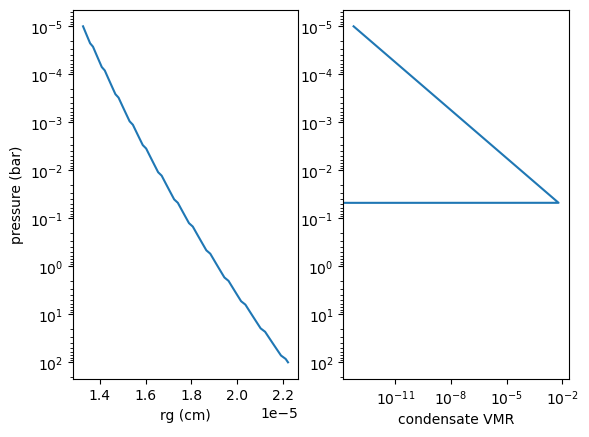

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(rg_layer,Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(122)
plt.plot(VMRc,Parr)
plt.xlabel("condensate VMR")
plt.yscale("log")
plt.xscale("log")
ax.invert_yaxis()

`rg` is almost constant through the vertical distribution. So, let's set a mean value here. `miegrid_interpolated_value` method interpolates the original parameter set given by MiQ_lognormal in PyMieScatt. See https://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_Lognormal. The number of the original parameters are seven, Bext, Bsca, Babs, G, Bpr, Bback, and Bratio. 

In [12]:
rg = 1.8e-5
mieQpar = pdb_nh3.miegrid_interpolated_values(rg, sigmag)
#beta0, omega, g = pdb_nh3.(rg,sigmag)

Plots the extinction coefficient for instance (index=0) and some approximation from the Heng's textbook .

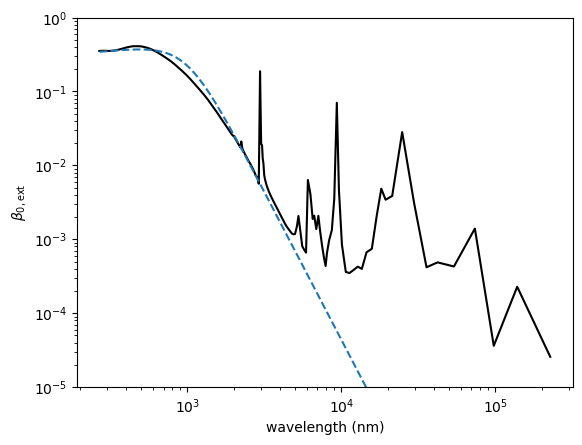

In [13]:

# approximate model (i.e. Heng's text paper)
x = 2*np.pi*(rg*np.exp(np.log(sigmag)**2/2.0))/(pdb_nh3.refraction_index_wavelength_nm*1.e-7)
Q0 = 10.
qe = 5/(Q0*x**-4 + x**0.2)*0.1

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(pdb_nh3.refraction_index_wavelength_nm, mieQpar[:,0],color="black")  #Bext, Bsca, Babs, G, Bpr, Bback, Bratio
plt.plot(pdb_nh3.refraction_index_wavelength_nm, qe, ls="dashed")
plt.ylim(1.e-5,1.e0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavelength (nm)")
plt.ylabel("$\\beta_{0, \mathrm{ext}}$")
plt.savefig("miefig.png")

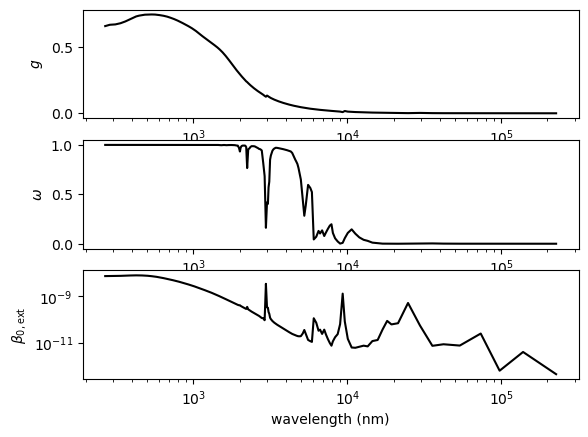

In [ ]:
#plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure()
ax = fig.add_subplot(311)
plt.plot(pdb_nh3.refraction_index_wavelength_nm, g[50,:],color="black")  #Bext, Bsca, Babs, G, Bpr, Bback, Bratio
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(pdb_nh3.refraction_index_wavelength_nm, omega[50,:],label="single scattering albedo",color="black") 
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(pdb_nh3.refraction_index_wavelength_nm, beta0[50,:],label="extinction",color="black") 
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavelength (nm)")
plt.ylabel("$\\beta_{0, \mathrm{ext}}$")
plt.savefig("miefig.png")